In [3]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima

Load data, sort by date, and display first 5 entries

In [4]:
data = pd.read_csv("../salesmanager/data_raw.csv", parse_dates=["date"])
data = data.sort_values(by="date")

data.head()

,transaction_id,date,customer_id,gender,age,product_category,quantity,price_per_unit,total_amount
521,522,2023-01-01,CUST522,Male,46,Beauty,3,500,1500
179,180,2023-01-01,CUST180,Male,41,Clothing,3,300,900
558,559,2023-01-01,CUST559,Female,40,Clothing,4,300,1200
302,303,2023-01-02,CUST303,Male,19,Electronics,3,30,90
978,979,2023-01-02,CUST979,Female,19,Beauty,1,25,25


In [5]:
# Ensure 0 missing values
assert data.isnull().sum().sum() == 0 and data.isna().sum().sum() == 0, "There are null values in the dataset"

# Separate "product_category" (prodcat) column into multiple binary columns
# Create binary columns for each product category, but keep the original column
prodcat_dummies = pd.get_dummies(data["product_category"], prefix="prodcat", drop_first=False)
data = pd.concat([data, prodcat_dummies], axis=1)

# Map gender column values to binary
data["gender"] = data["gender"].map({"Male": 1, "Female": 0})

¿What tasks are we going to perform?

1. Time Series Forecasting - Autoregressive prediction of "total_amount" column future values from past entries (marked by "date" column).
2. Time Series Forecasting - Same as 1 but separating by product category.

Try also a model able to incorporate the rest of the column to improve performance.

### 1. Forecasting weekly total amount with basic ARIMA

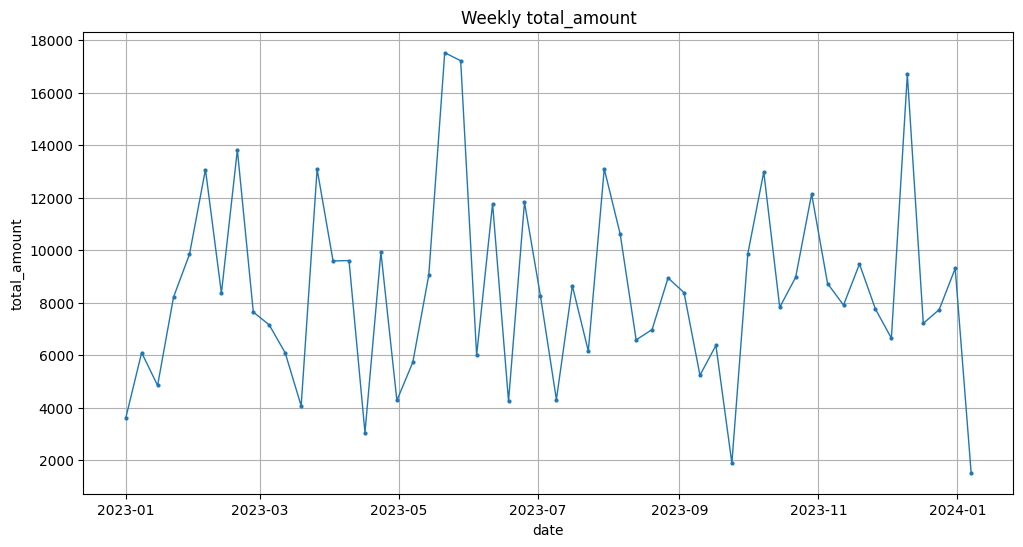

In [6]:
# Create a subset of the data containing total_amount column and date as index
total_amount = data[["date", "total_amount"]].copy()
total_amount = total_amount.set_index("date")

# Group values weekly
total_amount = total_amount.resample("W").sum()

# Plot the weekly total amount
plt.figure(figsize=(12, 6))
plt.plot(total_amount.index, total_amount["total_amount"], marker='o', linestyle='-', linewidth=1, markersize=2)
plt.title("Weekly total_amount")
plt.xlabel("date")
plt.ylabel("total_amount")
plt.grid()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=844.158, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=794.700, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=830.065, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=787.191, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=789.088, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=785.733, Time=0.09 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=783.614, Time=0.16 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=789.162, Time=0.02 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=785.066, Time=0.13 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=791.800, Time=0.09 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=787.099, Time=0.05 se

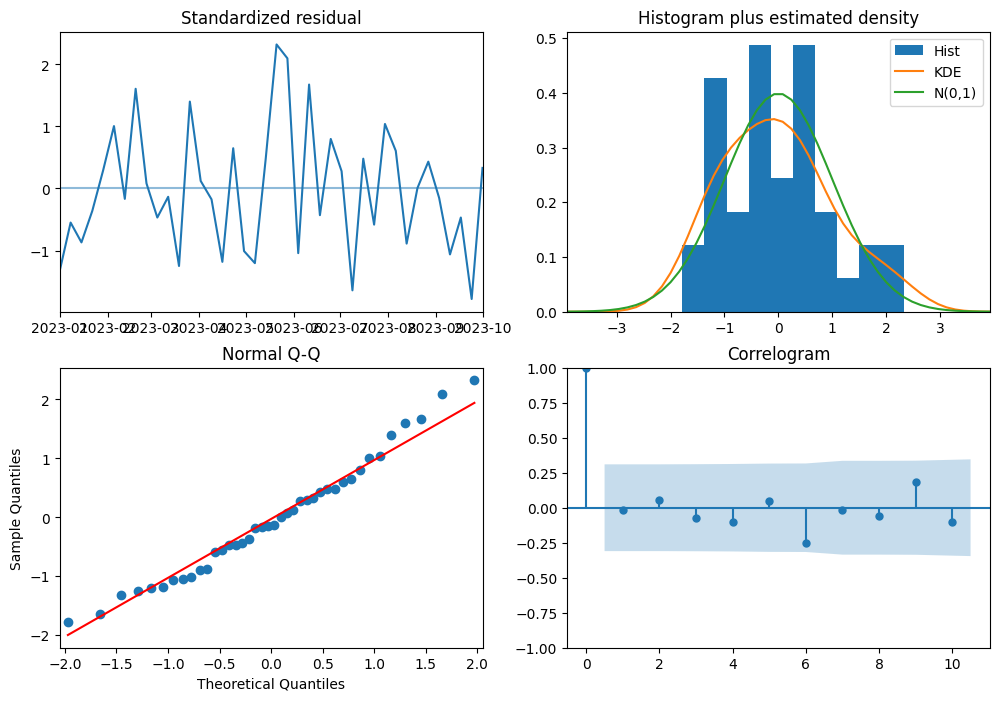

In [7]:
# Use the first 75% of the data for training and the rest for testing
train_end_idx = int(len(total_amount) * 0.75)

# ignore pmdarima future warning to have a clearer output
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically find best:
## p (AR order, i.e., number of past observations considered).
## d (degree of differencing) 
## q (MA order, i.e., number of past forecast errors considered)
model = auto_arima(
    y=total_amount["total_amount"][:train_end_idx],
    seasonal=False,       # Use True for seasonal ARIMA (SARIMA)
    stepwise=True,        # Fast stepwise search
    trace=True            # Print the search process
)

print(model)
# set figsize and fontsize
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 10})
model.plot_diagnostics()
plt.show()

Retrain and test the ARIMA model with the best params found in the previous cell

Mean Absolute Percentage Error: 0.57


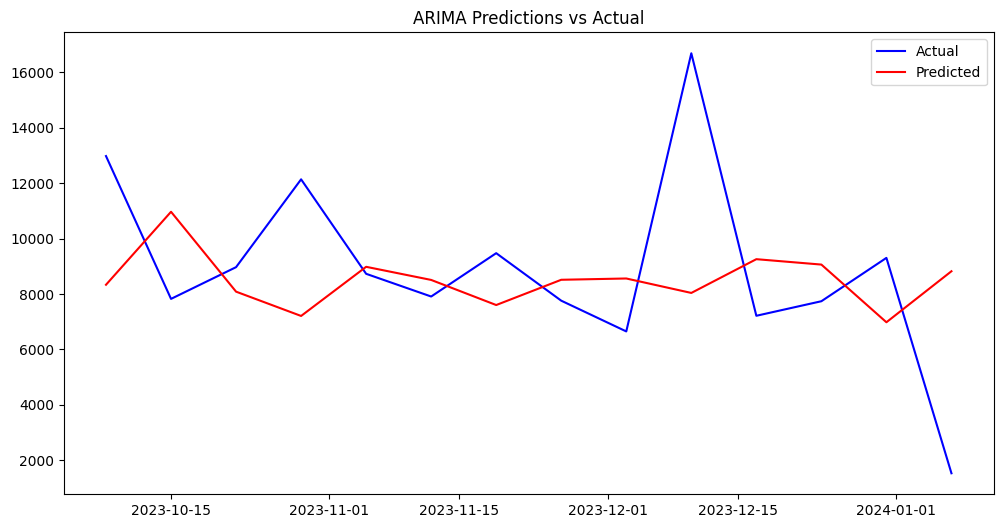

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# Iteratively forecast the next period in the test set and compare to real
predictions = []
for i in range(train_end_idx, len(total_amount)):
    model = ARIMA(total_amount["total_amount"][:i], order=(3, 0, 0))
    model_fit = model.fit()
    pred = model_fit.forecast(steps=1)
    predictions.append(pred)

# Mean absolute percentage error
from sklearn.metrics import mean_absolute_percentage_error as mape
mape_score = mape(total_amount["total_amount"][train_end_idx:], predictions)
print(f"Mean Absolute Percentage Error: {mape_score:.2f}")

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(total_amount["total_amount"][train_end_idx:], label="Actual", color="blue")
plt.plot(total_amount["total_amount"][train_end_idx:].index, predictions, label="Predicted", color="red")
plt.title("ARIMA Predictions vs Actual")
plt.legend()
plt.show()
